In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import class_weight
import pickle

In [18]:
DATASET_PATH = 'dataset'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = full_dataset.class_names
num_classes = len(class_names)
print("Kelas:", class_names)

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

print(f"Total Batches: {dataset_size}")
print(f"Train Batches: {train_size}")
print(f"Val Batches: {val_size}")
print(f"Test Batches: {test_size}")

train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size).take(val_size)
test_ds = full_dataset.skip(train_size + val_size).take(test_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10397 files belonging to 12 classes.
Kelas: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Total Batches: 325
Train Batches: 260
Val Batches: 32
Test Batches: 33


In [19]:
total_samples = 0
class_counts = []

for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    count = len(os.listdir(class_dir))
    class_counts.append(count)
    total_samples += count

print(f"Total Sampel: {total_samples}")

class_weights = {}
for i, count in enumerate(class_counts):
    weight = total_samples / (num_classes * count)
    class_weights[i] = weight

print("\nBobot Kelas:")
for i, weight in class_weights.items():
    print(f"  - Kelas '{class_names[i]}' {weight:.2f}")

Total Sampel: 10397

Bobot Kelas:
  - Kelas 'battery' 0.92
  - Kelas 'biological' 0.88
  - Kelas 'brown-glass' 1.43
  - Kelas 'cardboard' 0.97
  - Kelas 'clothes' 0.79
  - Kelas 'green-glass' 1.38
  - Kelas 'metal' 1.13
  - Kelas 'paper' 0.83
  - Kelas 'plastic' 1.00
  - Kelas 'shoes' 0.80
  - Kelas 'trash' 1.24
  - Kelas 'white-glass' 1.12


In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

In [21]:
IMG_SHAPE = IMAGE_SIZE + (3,)

base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model = Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
], name="garbage_classifier_v4")

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "garbage_classifier_v4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                             

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

MODEL_PATH = 'models/garbage_classifier_v4_balanced.h5'

model_checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)

Epoch 1/100
260/260 [==============================] - ETA: 0s - loss: 2.2123 - accuracy: 0.2731
Epoch 1: val_loss improved from inf to 1.51855, saving model to models\garbage_classifier_v4_balanced.h5
260/260 [==============================] - 145s 506ms/step - loss: 2.2123 - accuracy: 0.2731 - val_loss: 1.5186 - val_accuracy: 0.5537
Epoch 2/100
260/260 [==============================] - ETA: 0s - loss: 1.3013 - accuracy: 0.6208
Epoch 2: val_loss improved from 1.51855 to 0.99774, saving model to models\garbage_classifier_v4_balanced.h5
260/260 [==============================] - 120s 460ms/step - loss: 1.3013 - accuracy: 0.6208 - val_loss: 0.9977 - val_accuracy: 0.7490
Epoch 3/100
260/260 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.7288
Epoch 3: val_loss improved from 0.99774 to 0.77478, saving model to models\garbage_classifier_v4_balanced.h5
260/260 [==============================] - 118s 452ms/step - loss: 0.9620 - accuracy: 0.7288 - val_loss: 0.7748 - va

### PLOT ACCURACY & LOSS

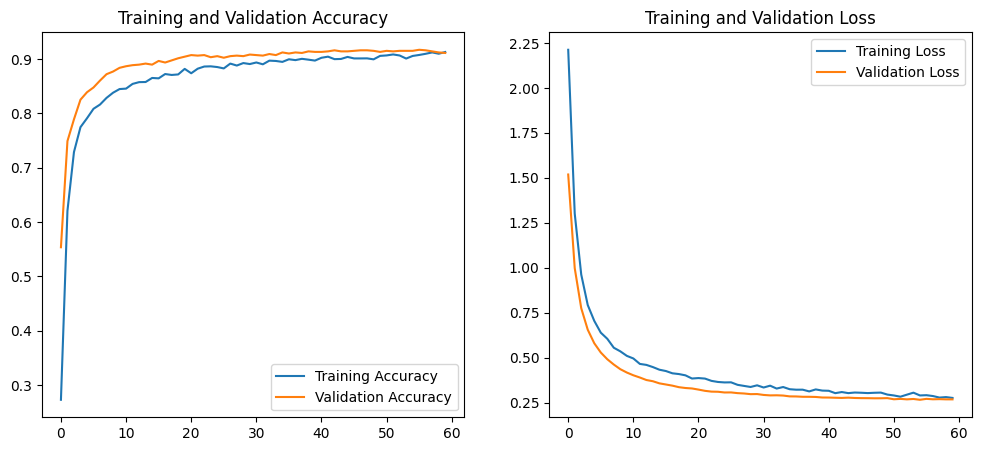

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

33/33 [==============================] - 17s 397ms/step


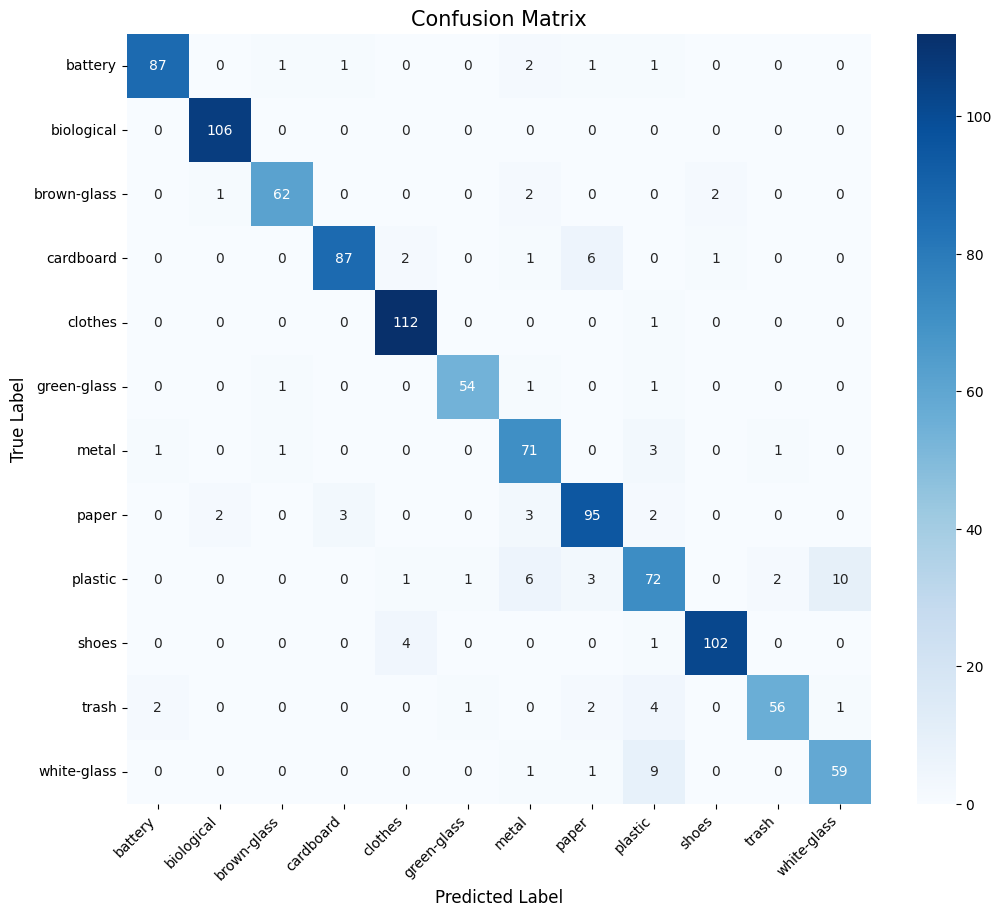

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', 
                      xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [25]:
print("\nFinal Evaluation")
results = model.evaluate(test_ds)

print("\n")
print("Hasil:")
print()
print(f"Loss pada Test Set    : {results[0]:.4f}")
print(f"Akurasi pada Test Set : {results[1] * 100:.2f}%")
print()


Final Evaluation
33/33 [==============================] - 12s 367ms/step - loss: 0.3040 - accuracy: 0.9145


Hasil:

Loss pada Test Set    : 0.3040
Akurasi pada Test Set : 91.45%



In [ ]:
CLASS_NAMES_PATH = 'models/class_names.pkl'
with open(CLASS_NAMES_PATH, 'wb') as f:
    pickle.dump(class_names, f)

print(f"\nModel: {MODEL_PATH}")
print(f"Nama kelas: {CLASS_NAMES_PATH}")


Model terbaik: models/garbage_classifier_v4_balanced.h5
Nama kelas: models/class_names.pkl
